<a href="https://colab.research.google.com/github/Spinkk/Implementing-ANNs-with-Tensorflow/blob/main/07/ANNw07.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import time
import datetime

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
import numpy as np

from sklearn.manifold import TSNE

# 1. Data

In [41]:
def preprocess_tfds(dataset, batch_size=64, buffer_size=1024, prefetch_factor=tf.data.experimental.AUTOTUNE):
    '''
    Create an input pipeline from tf.dataset. 
    Adjusted to only take input as there are no labels for autoencoders.

    :param dataset: tf.dataset to preprocess
    :param batch_size: int, default batch size is 64
    :param buffer_size: int, default is 1024
    :param prefetch_factor: int, default prefetch size is TF autotune
    :returns: preprocessed tf.dataset
    ''' 

    # create input pipeline using shuffling and batching (shuffle then batch)
    if buffer_size is not None and batch_size is not None:
        dataset = dataset.shuffle(buffer_size).batch(batch_size, drop_remainder=True)
    
    # casting of the images to float32 and expanding dim since no channel dim
    dataset = dataset.map(lambda img: tf.expand_dims(tf.cast(img, tf.float32), axis=-1), 
                          num_parallel_calls=tf.data.experimental.AUTOTUNE)

    # standardizing the images to 0 mean and 1 variance
    dataset = dataset.map(lambda img: tf.image.per_image_standardization(img), 
                          num_parallel_calls=tf.data.experimental.AUTOTUNE)

    # prefetch the dataset using AUTOTUNE to automatically find the optimal number of batches to prefetch
    if prefetch_factor is not None:
        dataset = dataset.prefetch(prefetch_factor)

    return dataset

In [3]:
# load data; no need for labels, as we train autoencoders
(train_ds, _), (test_ds, _) = tf.keras.datasets.fashion_mnist.load_data()

# make dataset
train_ds = tf.data.Dataset.from_tensor_slices(train_ds)
test_ds = tf.data.Dataset.from_tensor_slices(test_ds)

# preprocess
train_ds = preprocess_tfds(train_ds)
test_ds = preprocess_tfds(test_ds)

(64, 28, 28, 1)


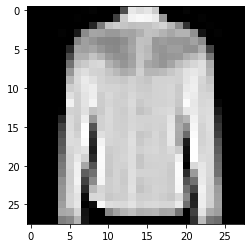

In [4]:
for img in train_ds.take(1):
    print(img.shape)
    plt.imshow(img[0,:,:,0], cmap='gray')

# 2.1. CNN Autoencoder

Use a fixed architecture based on fig D in https://towardsdatascience.com/convolutional-autoencoders-for-image-noise-reduction-32fce9fc1763.
For generality, one would need to infer ```restore_shape``` by returning dimension after last convolution in encoder.



In [5]:
class CNN_Encoder(tf.keras.layers.Layer):
    def __init__(self, input_dim, latent_dim):
        super(CNN_Encoder, self).__init__()
        
        self.layers = []
        
        # (2,2) strided convolution to downsample
        # padding=same for padding of the input image
        
        self.layers.append(tf.keras.layers.Conv2D(filters=32,
                                                  kernel_size=(3,3),
                                                  strides=(2,2),
                                                  padding='same',
                                                  input_shape=input_dim))  
        self.layers.append(tf.keras.layers.BatchNormalization())
        self.layers.append(tf.keras.layers.Activation('relu'))

        self.layers.append(tf.keras.layers.Conv2D(filters=64,
                                                  kernel_size=(3,3),
                                                  strides=(2,2),
                                                  padding='same'))  
        self.layers.append(tf.keras.layers.BatchNormalization())
        self.layers.append(tf.keras.layers.Activation('relu'))

        # dense layer to set dimension
        self.layers.append(tf.keras.layers.Flatten())
        self.layers.append(tf.keras.layers.Dense(latent_dim, activation='relu'))
        
    def call(self, x, training=False):
#         print(x.shape, "before, encode")
        for layer in self.layers:
            try:  # training argument only for BN layer
                x = layer(x, training) 
            except:
                x = layer(x)
#                 print(x.shape)
        return x


class CNN_Decoder(tf.keras.layers.Layer):
    def __init__(self, latent_dim, output_dim, restore_shape):
        super(CNN_Decoder, self).__init__()
        self.layers = []
        
        # dense layer to restore dim of flattend data
        self.layers.append(tf.keras.layers.Dense(units=3136,
                                                 input_shape=(latent_dim,)))
        self.layers.append(tf.keras.layers.BatchNormalization())
        self.layers.append(tf.keras.layers.Activation('relu'))
        
        # reshape to 3 dim with depth dim again
        self.layers.append(tf.keras.layers.Reshape(target_shape=restore_shape))
        
        # (2,2) strided transposed conv to upsample 
        
        self.layers.append(tf.keras.layers.Conv2DTranspose(filters=32,
                                                           kernel_size=(3,3),
                                                           strides=(2,2),
                                                           padding='same'))
        self.layers.append(tf.keras.layers.BatchNormalization())
        self.layers.append(tf.keras.layers.Activation('relu'))
       
        # restore image by convolution with image size
        self.layers.append(tf.keras.layers.Conv2DTranspose(filters=1,
                                                  kernel_size=(3,3),
                                                  strides=(2,2),
                                                  padding='same'))  
        self.layers.append(tf.keras.layers.BatchNormalization())
        self.layers.append(tf.keras.layers.Activation('sigmoid'))
       
    def call(self, x, training=False):
#         print(x.shape, "before, decode")
        for layer in self.layers:
            try:  # training argument only for BN layer
                x = layer(x, training) 
            except:
                x = layer(x)
#                 print(x.shape)
        return x


class CNN_Autoencoder(tf.keras.Model):
    def __init__(self, input_dim, latent_dim):
        super(CNN_Autoencoder, self).__init__()
        # encoder and decoder are symmetric
        self.encoder = CNN_Encoder(input_dim=input_dim,
                                   latent_dim=latent_dim)
        self.decoder = CNN_Decoder(latent_dim=latent_dim,
                                   output_dim=input_dim,
                                   restore_shape=(7,7,64))  # currently manual
        
    def call(self, x, training=False):
        x = self.encoder(x, training)
        self.latent_repr = x  # keep latent_repr as property in case it should be analyzed
        x = self.decoder(x, training)
        return x
    

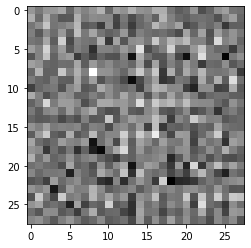

In [6]:
autoencoder = CNN_Autoencoder((None,28,28,1), 10)

# try autoencoder before training
for img in train_ds.take(1):
    res = autoencoder(img)
#     print(img.shape)
#     print(res.shape)
    plt.imshow(img[0,:,:,0], cmap='gray')
    plt.imshow(res[0,:,:,0], cmap='gray')

# 2.2 VAE-Autoencoder

In [159]:
class Encoder(tf.keras.layers.Layer):
    def __init__(self, latent_dim):
        super(Encoder, self).__init__()
        self.layers = [tf.keras.layers.InputLayer(input_shape=(28, 28, 1)),
                       tf.keras.layers.Conv2D(
                            filters=32, kernel_size=3, strides=(2, 2), activation='relu'),
                       tf.keras.layers.Conv2D(
                            filters=64, kernel_size=3, strides=(2, 2), activation='relu'),
                       tf.keras.layers.Flatten(),
                        # No activation
                       tf.keras.layers.Dense(latent_dim + latent_dim)]
        
    def call(x):
        for layer in self.layers:
            x = layer(x)

class Decoder(tf.keras.layers.Layer):
    def __init__(self, latent_dim):
        super(Decoder, self).__init__()
        self.layers = [tf.keras.layers.InputLayer(input_shape=(latent_dim,)),
                       tf.keras.layers.Dense(units=7*7*32, activation=tf.nn.relu),
                       tf.keras.layers.Reshape(target_shape=(7, 7, 32)),
                       tf.keras.layers.Conv2DTranspose(
                            filters=64, kernel_size=3, strides=2, padding='same',
                            activation='relu'),
                       tf.keras.layers.Conv2DTranspose(
                            filters=32, kernel_size=3, strides=2, padding='same',
                            activation='relu'),
                        # No activation
                       tf.keras.layers.Conv2DTranspose(
                            filters=1, kernel_size=3, strides=1, padding='same')]
        
    def call(x):
        for layer in self.layers:
            x = layer(x)


class CVAE(tf.keras.Model):
    """Convolutional variational autoencoder."""

    def __init__(self, latent_dim):
        super(CVAE, self).__init__()
        self.latent_dim = latent_dim

        self.encoder = Encoder(latent_dim)
        self.decoder = Decoder(latent_dim)

    @tf.function
    def sample(self, eps=None):
        if eps is None:
            eps = tf.random.normal(shape=(100, self.latent_dim))
        return self.decode(eps, apply_sigmoid=True)

    def encode(self, x):
        mean, logvar = tf.split(self.encoder(x), num_or_size_splits=2, axis=1)
        return mean, logvar

    def reparameterize(self, mean, logvar):
        eps = tf.random.normal(shape=mean.shape)
        return eps * tf.exp(logvar * .5) + mean

    def decode(self, z, apply_sigmoid=False):
        logits = self.decoder(z)
        if apply_sigmoid:
            probs = tf.sigmoid(logits)
            return probs
        return logits

In [147]:
def log_normal_pdf(sample, mean, logvar, raxis=1):
    log2pi = tf.math.log(2. * np.pi)
    
    return tf.reduce_sum(-.5 * ((sample - mean) ** 2. * tf.exp(-logvar) + logvar + log2pi), axis=raxis)

def compute_loss(model, x):
    mean, logvar = model.encode(x)
    z = model.reparameterize(mean, logvar)
    x_logit = model.decode(z)
    
    cross_ent = tf.nn.sigmoid_cross_entropy_with_logits(logits=x_logit, labels=x)
    
    logpx_z = -tf.reduce_sum(cross_ent, axis=[1, 2, 3])
    logpz = log_normal_pdf(z, 0., 0.)
    logqz_x = log_normal_pdf(z, mean, logvar)
    
    return -tf.reduce_mean(logpx_z + logpz - logqz_x)

In [168]:
#@tf.function
def train_step_VAE(model, train_ds, optimizer, train_loss_metric):
    '''
    Training for one epoch. Adjusted for Autoencoder as there are no acc_metric.
    '''
    for img in train_ds:  # there are no (input,label) pairs
        with tf.GradientTape() as tape:
            # forward pass
            loss = compute_loss(model, img) # autoencoder should try to get the original image back

        # backward pass
        gradients = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))

        # update metrics
        train_loss_metric.update_state(loss)

#@tf.function
def eval_step_VAE(model, ds, loss_metric):
    '''
    Evaluate without training. Adjusted for autoencoder. 
    Return a random image and reconstructed version of it.
    '''
    prediction = 0.0
    img = 0.0
    
    for img in ds:
        # forward pass
        # update metrics
        loss = compute_loss(model, img)
        loss_metric.update_state(loss)
    return img, prediction  # original img, reconstructed img from last sample

# 3. Train/test and visualize Autoencoder
Tried increasing epochs (to 20) and latent dim (to 50) but no substantial imporvement

In [7]:
class Timer():
    """
    A small class to measure time during training.
    """
    def __init__(self):
        self._start_time = None

    def start(self):
        """
        Start a new timer
        """
        if self._start_time is not None:
            print(f"Timer is running. Use .stop() to stop it")
            return None

        self._start_time = time.perf_counter()

    def stop(self):
        """
        Stop the timer, and report the elapsed time
        """
        if self._start_time is None:
            print(f"Timer is not running. Use .start() to start it")
            return 0
    
        elapsed_time = time.perf_counter() - self._start_time
        self._start_time = None
        return elapsed_time  


@tf.function
def train_step(model, train_ds, loss_function, optimizer, train_loss_metric):
    '''
    Training for one epoch. Adjusted for Autoencoder as there are no acc_metric.
    '''
    for img in train_ds:  # there are no (input,label) pairs
        with tf.GradientTape() as tape:
            # forward pass
            prediction = model(img, training=True)
            loss = loss_function(img, prediction) # autoencoder should try to get the original image back

            # enable when training with l2 regulizer and switch next line to tape.gradient(loss_reg, model.trainable_variables)
#             loss_reg = loss + tf.reduce_sum(model.losses)

        # backward pass
        gradients = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))

        # update metrics
        train_loss_metric.update_state(loss)

@tf.function
def eval_step(model, ds, loss_function, loss_metric):
    '''
    Evaluate without training. Adjusted for autoencoder. 
    Return a random image and reconstructed version of it.
    '''
    prediction = 0.0
    img = 0.0
    
    for img in ds:
        # forward pass
        prediction = model(img, training=False)
        # update metrics
        loss = loss_function(img, prediction)
        loss_metric.update_state(loss)
    return img, prediction  # original img, reconstructed img from last sample

In [8]:
# @Hyperparameter
EPOCHS = 100
LEARNING_RATE = 0.001

tf.keras.backend.clear_session()
timer = Timer()

# Define @model
model = CNN_Autoencoder(input_dim=(None,28,28,1), latent_dim=10)
# Define @loss function
loss_function = tf.keras.losses.MeanSquaredError()
# Define @optimizer
optimizer = tf.keras.optimizers.Adam(LEARNING_RATE)

# get summary of the model
model.build((None,28,28,1)) # needed for summary
model.summary()

Model: "cnn__autoencoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
cnn__encoder (CNN_Encoder)   multiple                  50570     
_________________________________________________________________
cnn__decoder (CNN_Decoder)   multiple                  65925     
Total params: 116,495
Trainable params: 109,965
Non-trainable params: 6,530
_________________________________________________________________


In [9]:
train_loss_metric = tf.keras.metrics.Mean('train_loss')
test_loss_metric = tf.keras.metrics.Mean('test_loss')

# Initialize lists for later visualization.
train_losses = []
test_losses = []
times = []

[INFO] - Evaluating the Dataset on the cnn__autoencoder before training.
train_loss: 1.2500, test_loss: 1.2500

[EPOCH] ____________________0____________________
[0] - Finished Epoch in 3.43 seconds - train_loss: 0.7792; test_loss: 0.6810

[INFO] - Total time elapsed: 0.0830 min. Total time remaining: 8.2154 min.


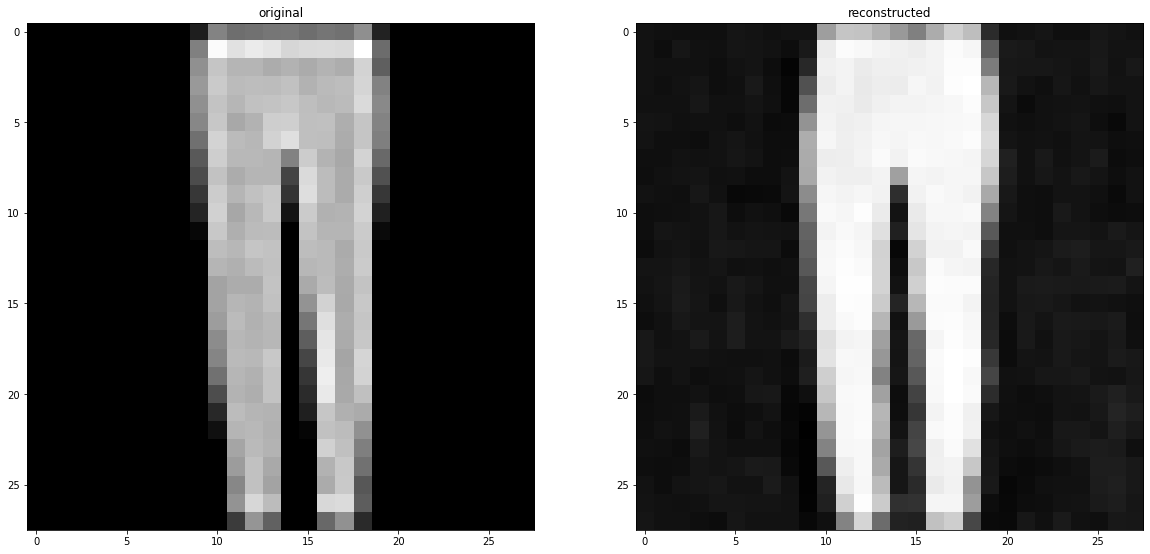


[EPOCH] ____________________1____________________
[1] - Finished Epoch in 3.11 seconds - train_loss: 0.6492; test_loss: 0.6246

[EPOCH] ____________________2____________________
[2] - Finished Epoch in 3.04 seconds - train_loss: 0.6121; test_loss: 0.6008

[EPOCH] ____________________3____________________
[3] - Finished Epoch in 3.00 seconds - train_loss: 0.5948; test_loss: 0.5873

[EPOCH] ____________________4____________________
[4] - Finished Epoch in 2.95 seconds - train_loss: 0.5851; test_loss: 0.5826

[EPOCH] ____________________5____________________
[5] - Finished Epoch in 2.91 seconds - train_loss: 0.5794; test_loss: 0.5767

[INFO] - Total time elapsed: 0.3332 min. Total time remaining: 5.2199 min.


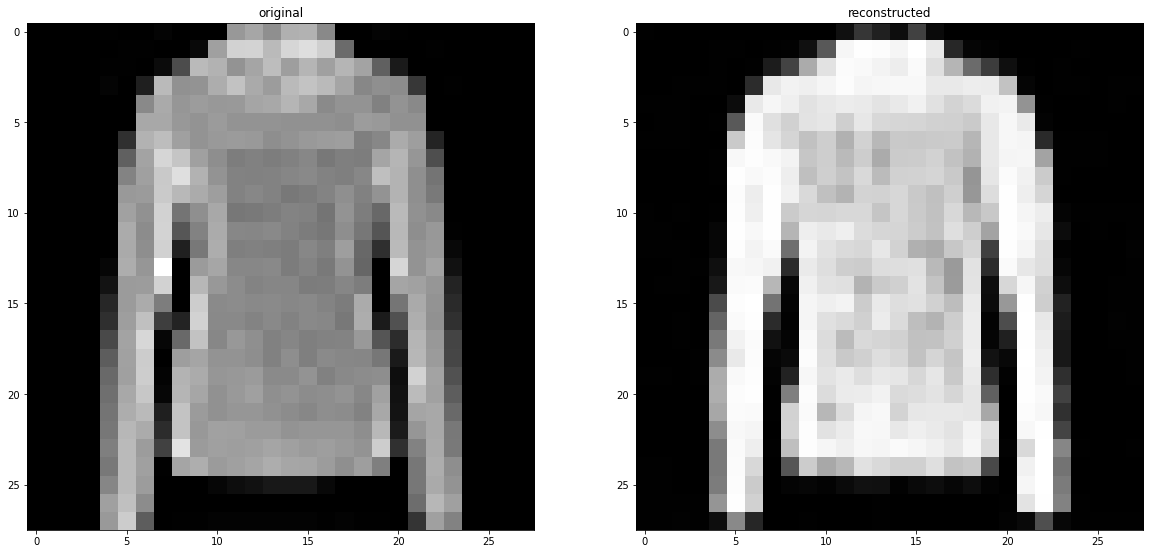


[EPOCH] ____________________6____________________
[6] - Finished Epoch in 2.87 seconds - train_loss: 0.5756; test_loss: 0.5743

[EPOCH] ____________________7____________________
[7] - Finished Epoch in 2.89 seconds - train_loss: 0.5730; test_loss: 0.5713

[EPOCH] ____________________8____________________
[8] - Finished Epoch in 3.25 seconds - train_loss: 0.5711; test_loss: 0.5709

[EPOCH] ____________________9____________________
[9] - Finished Epoch in 3.25 seconds - train_loss: 0.5698; test_loss: 0.5683

[EPOCH] ____________________10____________________
[10] - Finished Epoch in 3.10 seconds - train_loss: 0.5688; test_loss: 0.5676

[INFO] - Total time elapsed: 0.5891 min. Total time remaining: 4.7660 min.


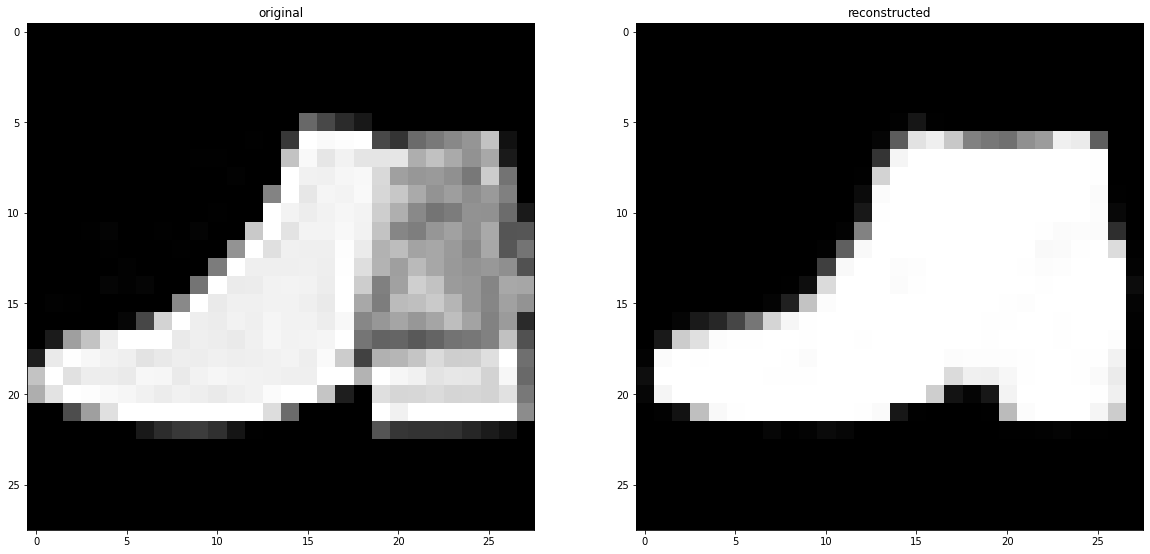


[EPOCH] ____________________11____________________
[11] - Finished Epoch in 3.27 seconds - train_loss: 0.5679; test_loss: 0.5690

[EPOCH] ____________________12____________________
[12] - Finished Epoch in 2.97 seconds - train_loss: 0.5675; test_loss: 0.5671

[EPOCH] ____________________13____________________
[13] - Finished Epoch in 2.89 seconds - train_loss: 0.5670; test_loss: 0.5667

[EPOCH] ____________________14____________________
[14] - Finished Epoch in 2.86 seconds - train_loss: 0.5663; test_loss: 0.5657

[EPOCH] ____________________15____________________
[15] - Finished Epoch in 2.99 seconds - train_loss: 0.5660; test_loss: 0.5666

[INFO] - Total time elapsed: 0.8386 min. Total time remaining: 4.4024 min.


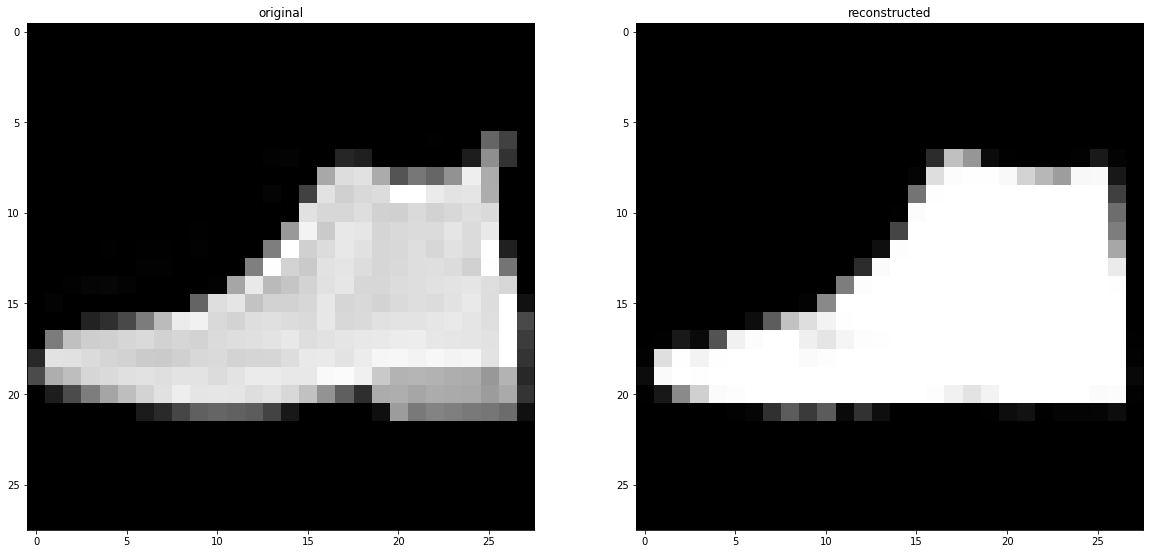


[EPOCH] ____________________16____________________
[16] - Finished Epoch in 3.13 seconds - train_loss: 0.5656; test_loss: 0.5649

[EPOCH] ____________________17____________________
[17] - Finished Epoch in 3.51 seconds - train_loss: 0.5653; test_loss: 0.5651

[EPOCH] ____________________18____________________
[18] - Finished Epoch in 3.50 seconds - train_loss: 0.5653; test_loss: 0.5645

[EPOCH] ____________________19____________________
[19] - Finished Epoch in 3.50 seconds - train_loss: 0.5649; test_loss: 0.5646

[EPOCH] ____________________20____________________
[20] - Finished Epoch in 3.41 seconds - train_loss: 0.5647; test_loss: 0.5639

[INFO] - Total time elapsed: 1.1225 min. Total time remaining: 4.2227 min.


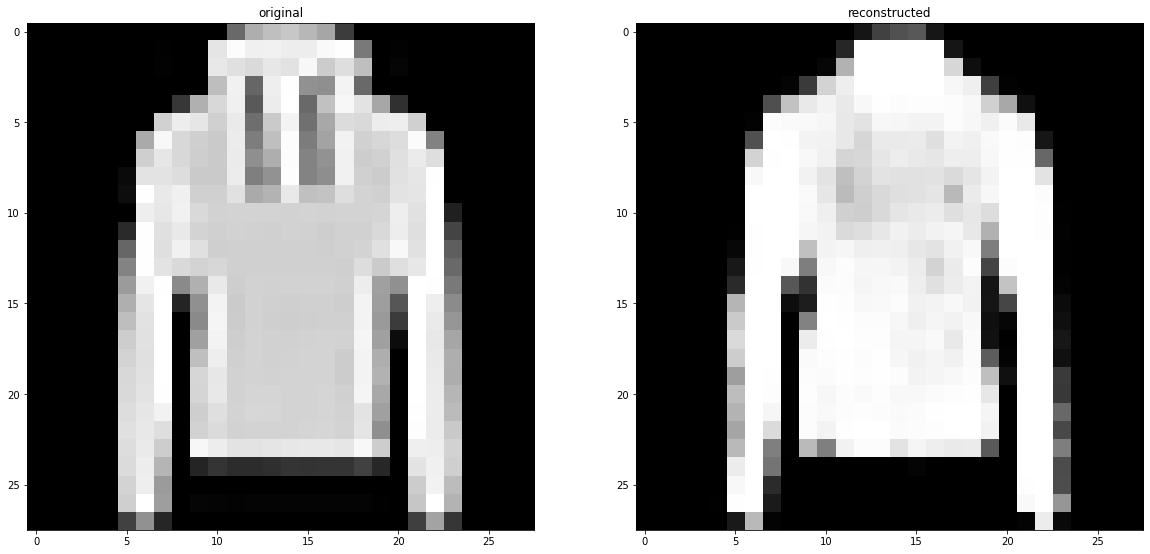


[EPOCH] ____________________21____________________
[21] - Finished Epoch in 3.35 seconds - train_loss: 0.5645; test_loss: 0.5635

[EPOCH] ____________________22____________________
[22] - Finished Epoch in 3.42 seconds - train_loss: 0.5643; test_loss: 0.5645

[EPOCH] ____________________23____________________
[23] - Finished Epoch in 2.87 seconds - train_loss: 0.5641; test_loss: 0.5634

[EPOCH] ____________________24____________________
[24] - Finished Epoch in 2.88 seconds - train_loss: 0.5639; test_loss: 0.5639

[EPOCH] ____________________25____________________
[25] - Finished Epoch in 2.92 seconds - train_loss: 0.5635; test_loss: 0.5640

[INFO] - Total time elapsed: 1.3796 min. Total time remaining: 3.9267 min.


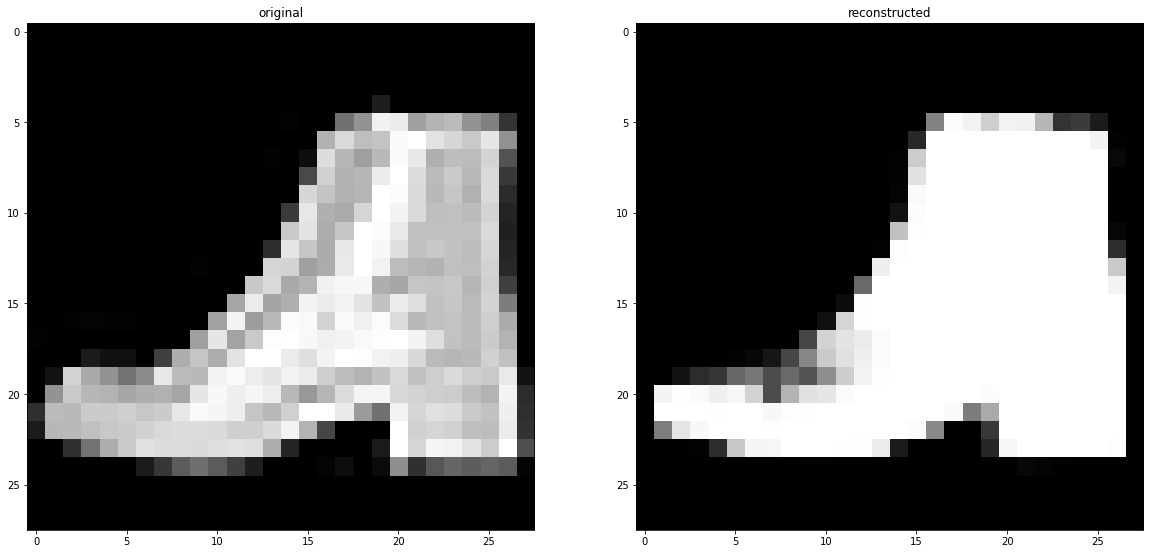


[EPOCH] ____________________26____________________
[26] - Finished Epoch in 2.96 seconds - train_loss: 0.5634; test_loss: 0.5632

[EPOCH] ____________________27____________________
[27] - Finished Epoch in 3.55 seconds - train_loss: 0.5635; test_loss: 0.5633

[EPOCH] ____________________28____________________
[28] - Finished Epoch in 3.41 seconds - train_loss: 0.5632; test_loss: 0.5634

[EPOCH] ____________________29____________________
[29] - Finished Epoch in 3.21 seconds - train_loss: 0.5631; test_loss: 0.5638

[EPOCH] ____________________30____________________
[30] - Finished Epoch in 3.19 seconds - train_loss: 0.5629; test_loss: 0.5625

[INFO] - Total time elapsed: 1.6517 min. Total time remaining: 3.6763 min.


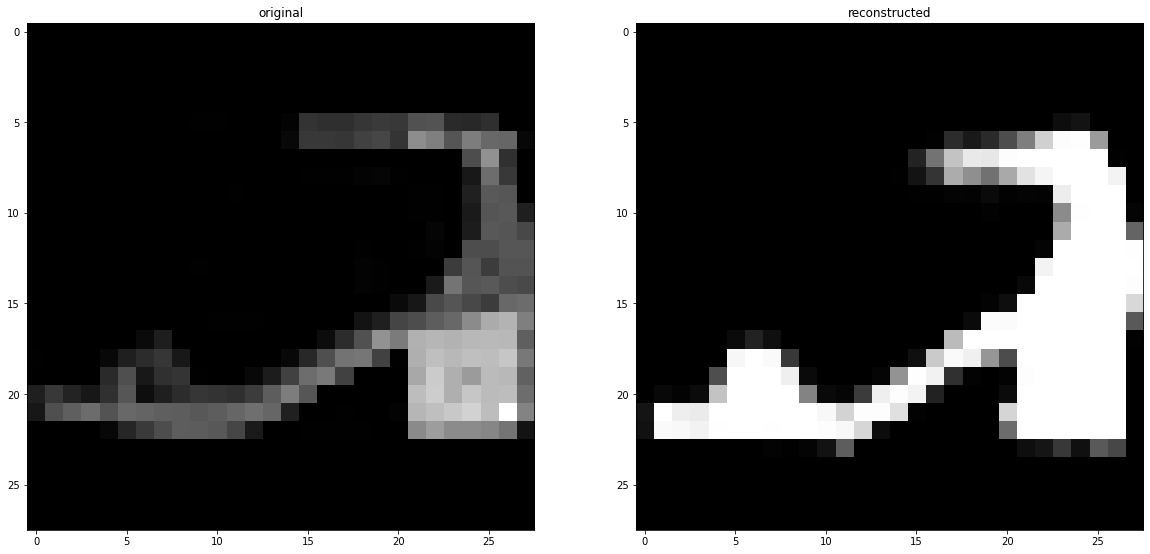


[EPOCH] ____________________31____________________
[31] - Finished Epoch in 3.16 seconds - train_loss: 0.5629; test_loss: 0.5630

[EPOCH] ____________________32____________________
[32] - Finished Epoch in 2.94 seconds - train_loss: 0.5628; test_loss: 0.5631

[EPOCH] ____________________33____________________
[33] - Finished Epoch in 2.88 seconds - train_loss: 0.5625; test_loss: 0.5622

[EPOCH] ____________________34____________________
[34] - Finished Epoch in 2.89 seconds - train_loss: 0.5625; test_loss: 0.5631

[EPOCH] ____________________35____________________
[35] - Finished Epoch in 3.41 seconds - train_loss: 0.5624; test_loss: 0.5623

[INFO] - Total time elapsed: 1.9063 min. Total time remaining: 3.3890 min.


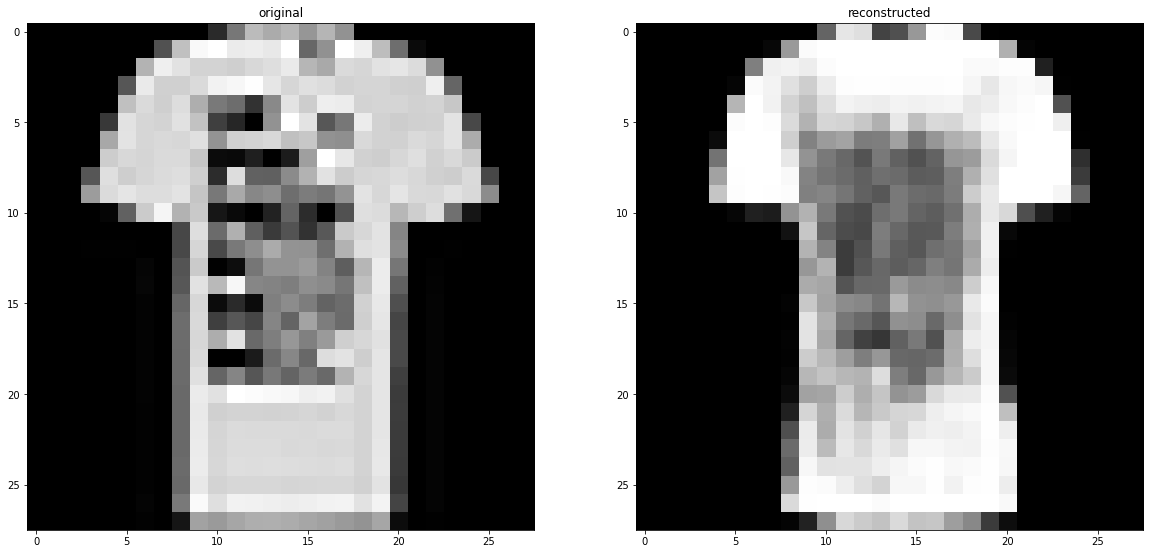


[EPOCH] ____________________36____________________
[36] - Finished Epoch in 3.65 seconds - train_loss: 0.5622; test_loss: 0.5624

[EPOCH] ____________________37____________________
[37] - Finished Epoch in 2.89 seconds - train_loss: 0.5620; test_loss: 0.5619

[EPOCH] ____________________38____________________
[38] - Finished Epoch in 2.84 seconds - train_loss: 0.5620; test_loss: 0.5620

[EPOCH] ____________________39____________________
[39] - Finished Epoch in 3.45 seconds - train_loss: 0.5621; test_loss: 0.5621

[EPOCH] ____________________40____________________
[40] - Finished Epoch in 3.11 seconds - train_loss: 0.5619; test_loss: 0.5614

[INFO] - Total time elapsed: 2.1720 min. Total time remaining: 3.1256 min.


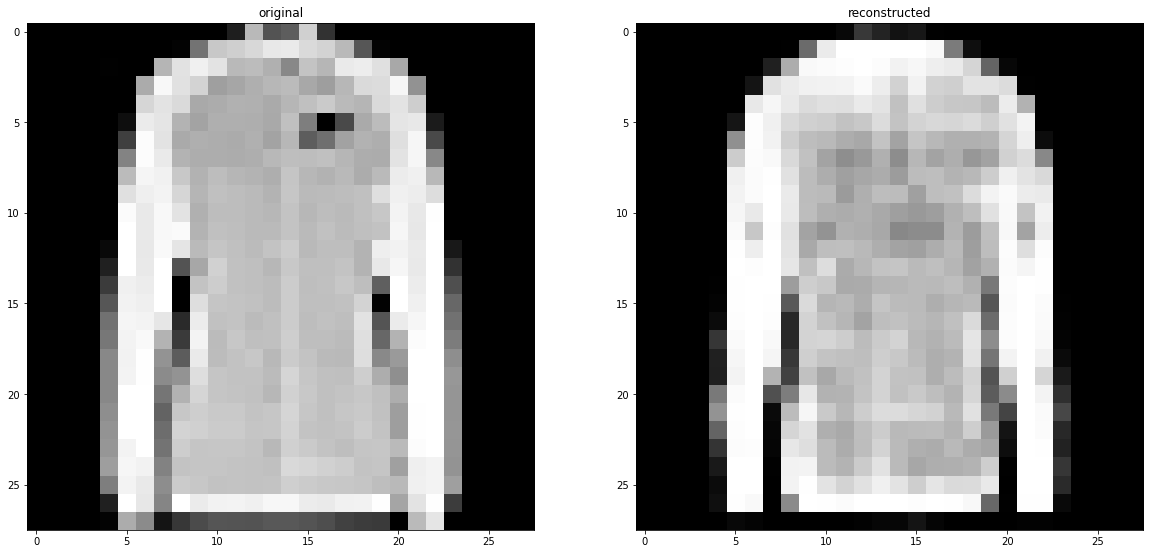


[EPOCH] ____________________41____________________
[41] - Finished Epoch in 2.83 seconds - train_loss: 0.5618; test_loss: 0.5620

[EPOCH] ____________________42____________________
[42] - Finished Epoch in 2.86 seconds - train_loss: 0.5618; test_loss: 0.5622

[EPOCH] ____________________43____________________
[43] - Finished Epoch in 2.90 seconds - train_loss: 0.5618; test_loss: 0.5622

[EPOCH] ____________________44____________________
[44] - Finished Epoch in 3.09 seconds - train_loss: 0.5615; test_loss: 0.5620

[EPOCH] ____________________45____________________
[45] - Finished Epoch in 3.08 seconds - train_loss: 0.5616; test_loss: 0.5610

[INFO] - Total time elapsed: 2.4182 min. Total time remaining: 2.8387 min.


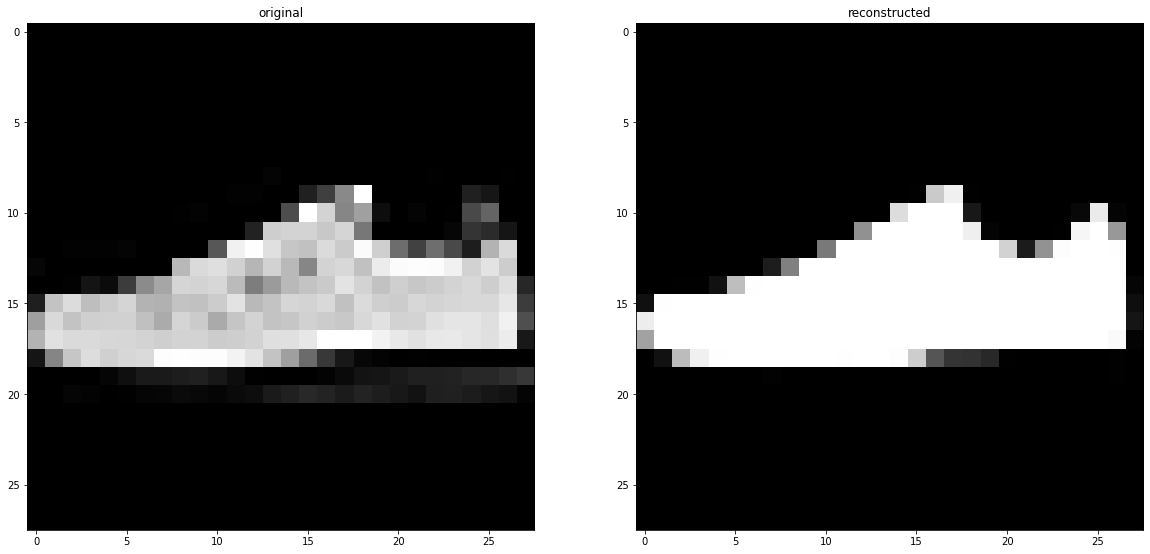


[EPOCH] ____________________46____________________
[46] - Finished Epoch in 2.95 seconds - train_loss: 0.5613; test_loss: 0.5620

[EPOCH] ____________________47____________________
[47] - Finished Epoch in 2.94 seconds - train_loss: 0.5613; test_loss: 0.5619

[EPOCH] ____________________48____________________
[48] - Finished Epoch in 2.98 seconds - train_loss: 0.5611; test_loss: 0.5614

[EPOCH] ____________________49____________________
[49] - Finished Epoch in 3.26 seconds - train_loss: 0.5610; test_loss: 0.5617

[EPOCH] ____________________50____________________
[50] - Finished Epoch in 3.73 seconds - train_loss: 0.5612; test_loss: 0.5616

[INFO] - Total time elapsed: 2.6826 min. Total time remaining: 2.5774 min.


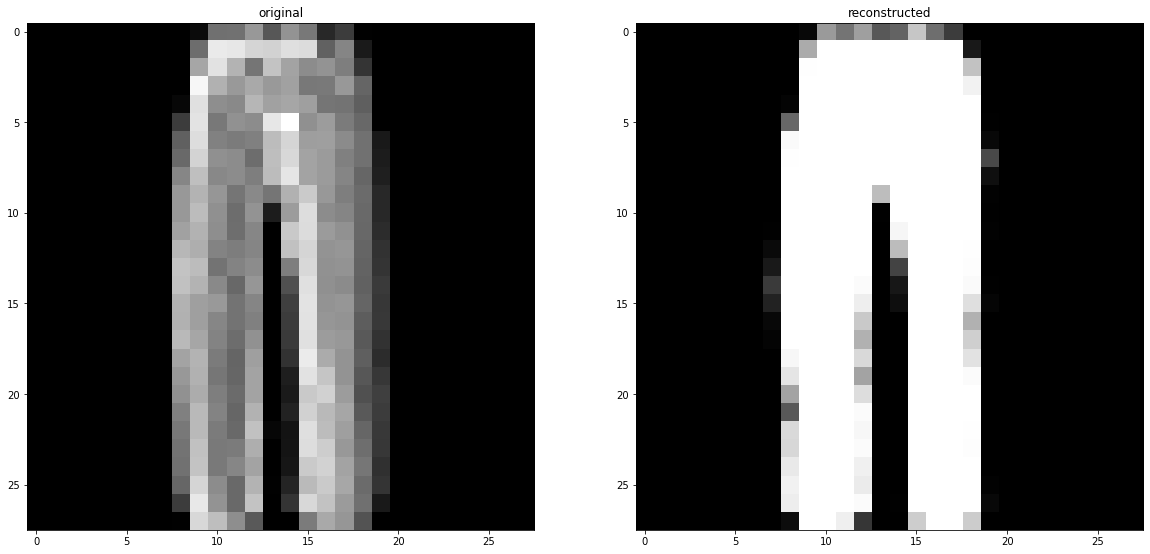


[EPOCH] ____________________51____________________
[51] - Finished Epoch in 3.74 seconds - train_loss: 0.5609; test_loss: 0.5615

[EPOCH] ____________________52____________________
[52] - Finished Epoch in 3.72 seconds - train_loss: 0.5611; test_loss: 0.5609

[EPOCH] ____________________53____________________
[53] - Finished Epoch in 3.13 seconds - train_loss: 0.5610; test_loss: 0.5617

[EPOCH] ____________________54____________________
[54] - Finished Epoch in 2.87 seconds - train_loss: 0.5610; test_loss: 0.5608

[EPOCH] ____________________55____________________
[55] - Finished Epoch in 2.92 seconds - train_loss: 0.5608; test_loss: 0.5613

[INFO] - Total time elapsed: 2.9558 min. Total time remaining: 2.3224 min.


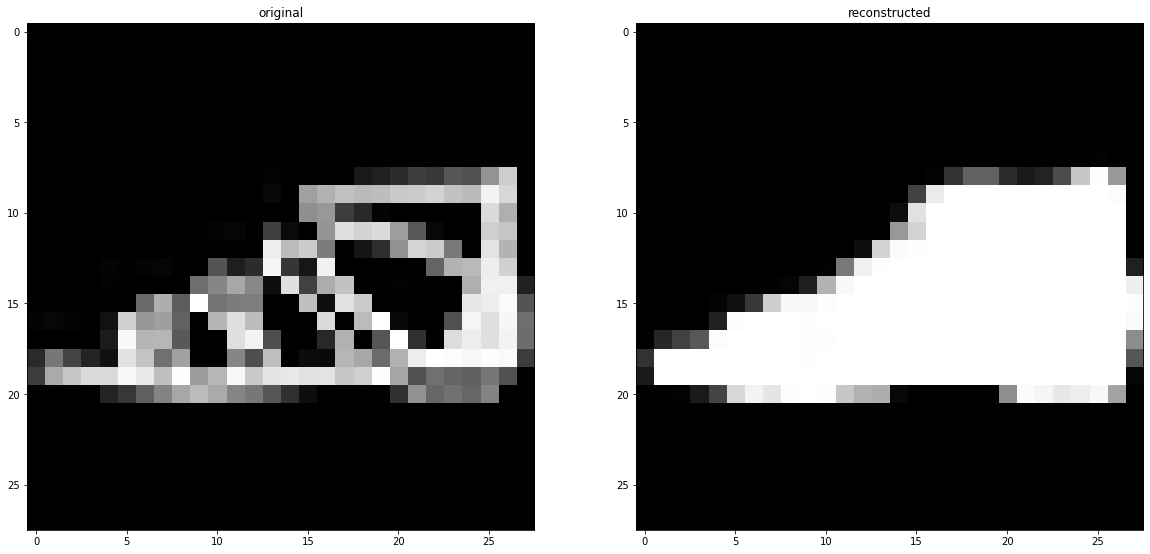


[EPOCH] ____________________56____________________
[56] - Finished Epoch in 2.94 seconds - train_loss: 0.5607; test_loss: 0.5610

[EPOCH] ____________________57____________________
[57] - Finished Epoch in 3.25 seconds - train_loss: 0.5608; test_loss: 0.5606

[EPOCH] ____________________58____________________
[58] - Finished Epoch in 3.01 seconds - train_loss: 0.5607; test_loss: 0.5611

[EPOCH] ____________________59____________________
[59] - Finished Epoch in 2.95 seconds - train_loss: 0.5606; test_loss: 0.5609

[EPOCH] ____________________60____________________
[60] - Finished Epoch in 2.86 seconds - train_loss: 0.5605; test_loss: 0.5606

[INFO] - Total time elapsed: 3.2060 min. Total time remaining: 2.0497 min.


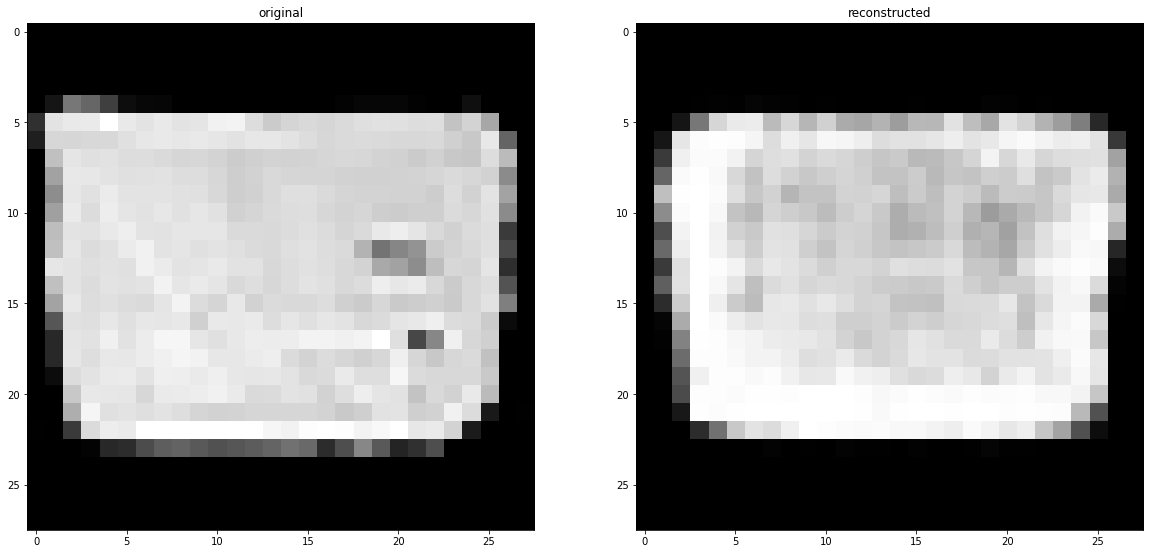


[EPOCH] ____________________61____________________
[61] - Finished Epoch in 2.96 seconds - train_loss: 0.5605; test_loss: 0.5606

[EPOCH] ____________________62____________________
[62] - Finished Epoch in 3.30 seconds - train_loss: 0.5604; test_loss: 0.5608

[EPOCH] ____________________63____________________
[63] - Finished Epoch in 3.81 seconds - train_loss: 0.5605; test_loss: 0.5604

[EPOCH] ____________________64____________________
[64] - Finished Epoch in 3.00 seconds - train_loss: 0.5604; test_loss: 0.5603

[EPOCH] ____________________65____________________
[65] - Finished Epoch in 3.54 seconds - train_loss: 0.5603; test_loss: 0.5610

[INFO] - Total time elapsed: 3.4828 min. Total time remaining: 1.7942 min.


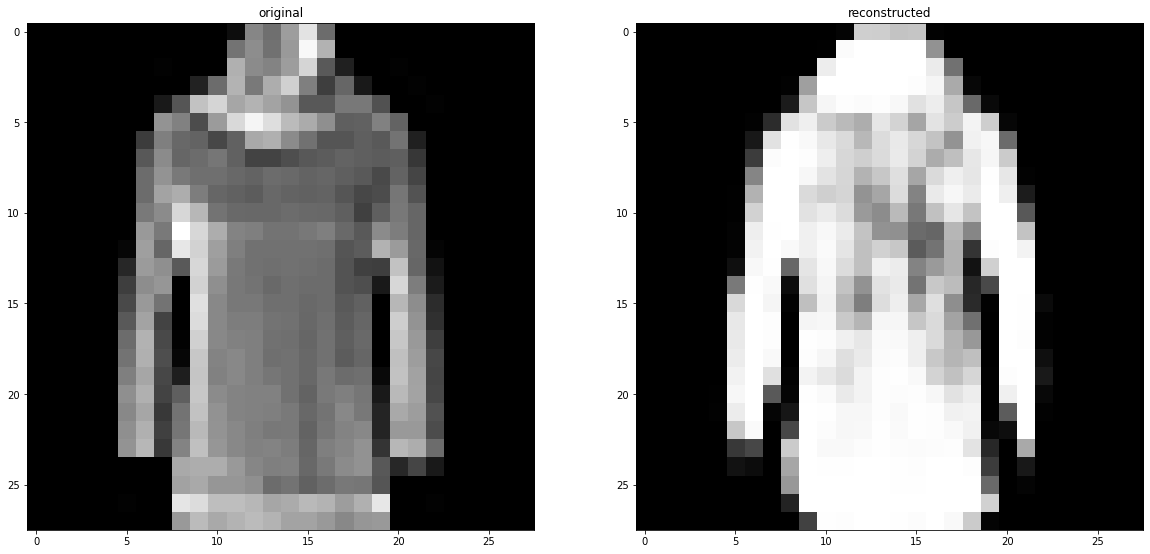


[EPOCH] ____________________66____________________
[66] - Finished Epoch in 3.76 seconds - train_loss: 0.5604; test_loss: 0.5607

[EPOCH] ____________________67____________________
[67] - Finished Epoch in 3.91 seconds - train_loss: 0.5602; test_loss: 0.5605

[EPOCH] ____________________68____________________
[68] - Finished Epoch in 4.15 seconds - train_loss: 0.5602; test_loss: 0.5604

[EPOCH] ____________________69____________________
[69] - Finished Epoch in 3.63 seconds - train_loss: 0.5602; test_loss: 0.5607

[EPOCH] ____________________70____________________
[70] - Finished Epoch in 3.31 seconds - train_loss: 0.5602; test_loss: 0.5604

[INFO] - Total time elapsed: 3.7956 min. Total time remaining: 1.5503 min.


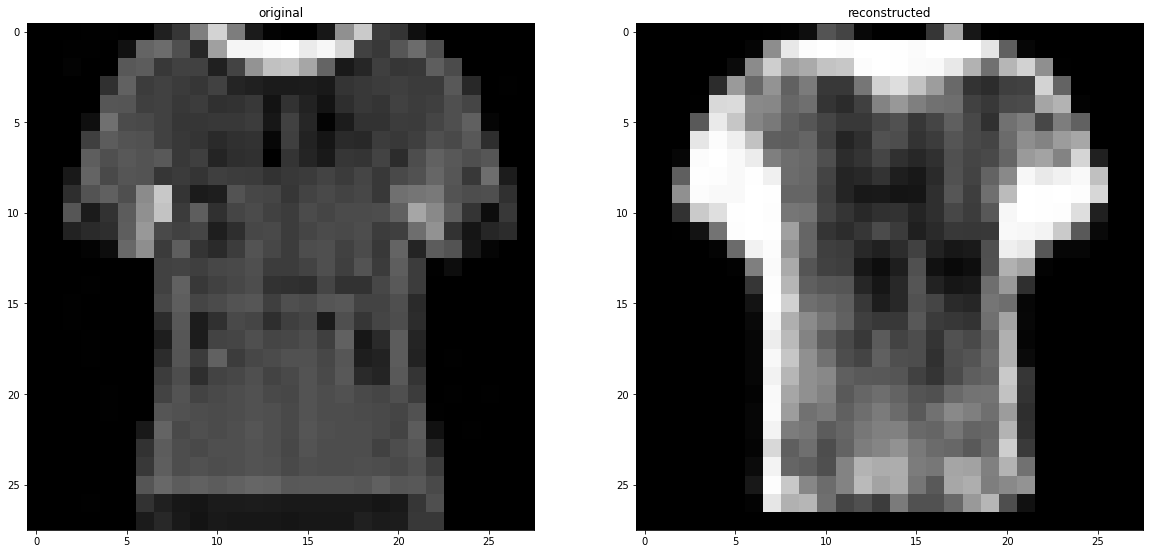


[EPOCH] ____________________71____________________
[71] - Finished Epoch in 3.07 seconds - train_loss: 0.5601; test_loss: 0.5605

[EPOCH] ____________________72____________________
[72] - Finished Epoch in 3.15 seconds - train_loss: 0.5600; test_loss: 0.5608

[EPOCH] ____________________73____________________
[73] - Finished Epoch in 3.00 seconds - train_loss: 0.5600; test_loss: 0.5602

[EPOCH] ____________________74____________________
[74] - Finished Epoch in 2.95 seconds - train_loss: 0.5602; test_loss: 0.5601

[EPOCH] ____________________75____________________
[75] - Finished Epoch in 2.97 seconds - train_loss: 0.5598; test_loss: 0.5611

[INFO] - Total time elapsed: 4.0479 min. Total time remaining: 1.2783 min.


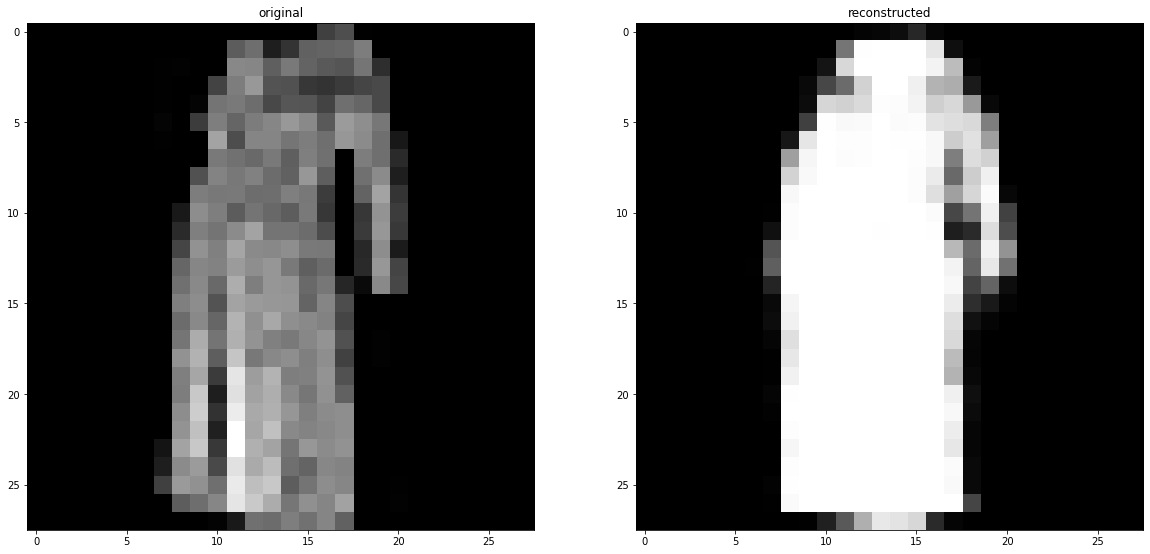


[EPOCH] ____________________76____________________
[76] - Finished Epoch in 3.03 seconds - train_loss: 0.5599; test_loss: 0.5606

[EPOCH] ____________________77____________________
[77] - Finished Epoch in 2.94 seconds - train_loss: 0.5599; test_loss: 0.5602

[EPOCH] ____________________78____________________
[78] - Finished Epoch in 2.99 seconds - train_loss: 0.5597; test_loss: 0.5601

[EPOCH] ____________________79____________________
[79] - Finished Epoch in 3.03 seconds - train_loss: 0.5597; test_loss: 0.5602

[EPOCH] ____________________80____________________
[80] - Finished Epoch in 3.07 seconds - train_loss: 0.5596; test_loss: 0.5602

[INFO] - Total time elapsed: 4.2990 min. Total time remaining: 1.0084 min.


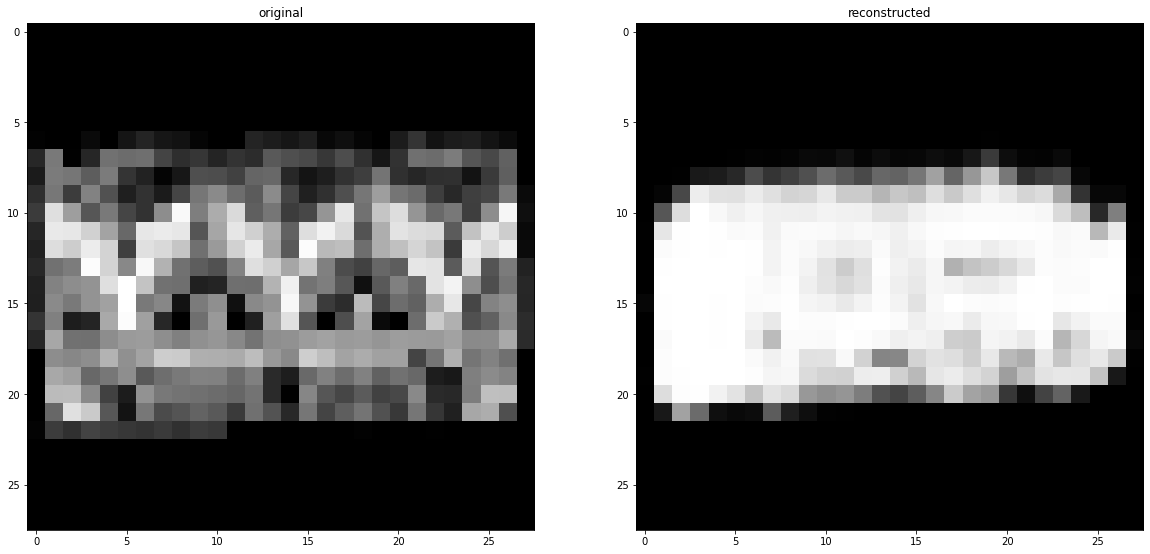


[EPOCH] ____________________81____________________
[81] - Finished Epoch in 3.01 seconds - train_loss: 0.5598; test_loss: 0.5601

[EPOCH] ____________________82____________________
[82] - Finished Epoch in 3.04 seconds - train_loss: 0.5597; test_loss: 0.5602

[EPOCH] ____________________83____________________
[83] - Finished Epoch in 2.92 seconds - train_loss: 0.5597; test_loss: 0.5607

[EPOCH] ____________________84____________________
[84] - Finished Epoch in 3.00 seconds - train_loss: 0.5597; test_loss: 0.5599

[EPOCH] ____________________85____________________
[85] - Finished Epoch in 3.28 seconds - train_loss: 0.5596; test_loss: 0.5601

[INFO] - Total time elapsed: 4.5533 min. Total time remaining: 0.7412 min.


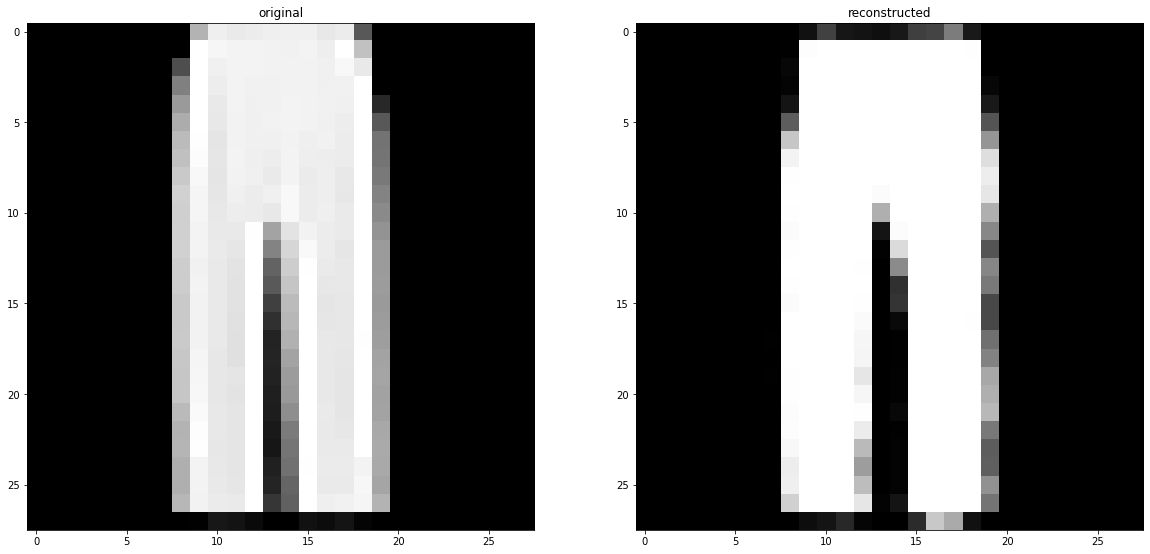


[EPOCH] ____________________86____________________
[86] - Finished Epoch in 3.52 seconds - train_loss: 0.5596; test_loss: 0.5601

[EPOCH] ____________________87____________________
[87] - Finished Epoch in 3.40 seconds - train_loss: 0.5594; test_loss: 0.5599

[EPOCH] ____________________88____________________
[88] - Finished Epoch in 3.68 seconds - train_loss: 0.5593; test_loss: 0.5605

[EPOCH] ____________________89____________________
[89] - Finished Epoch in 3.64 seconds - train_loss: 0.5595; test_loss: 0.5603

[EPOCH] ____________________90____________________
[90] - Finished Epoch in 3.52 seconds - train_loss: 0.5594; test_loss: 0.5599

[INFO] - Total time elapsed: 4.8493 min. Total time remaining: 0.4796 min.


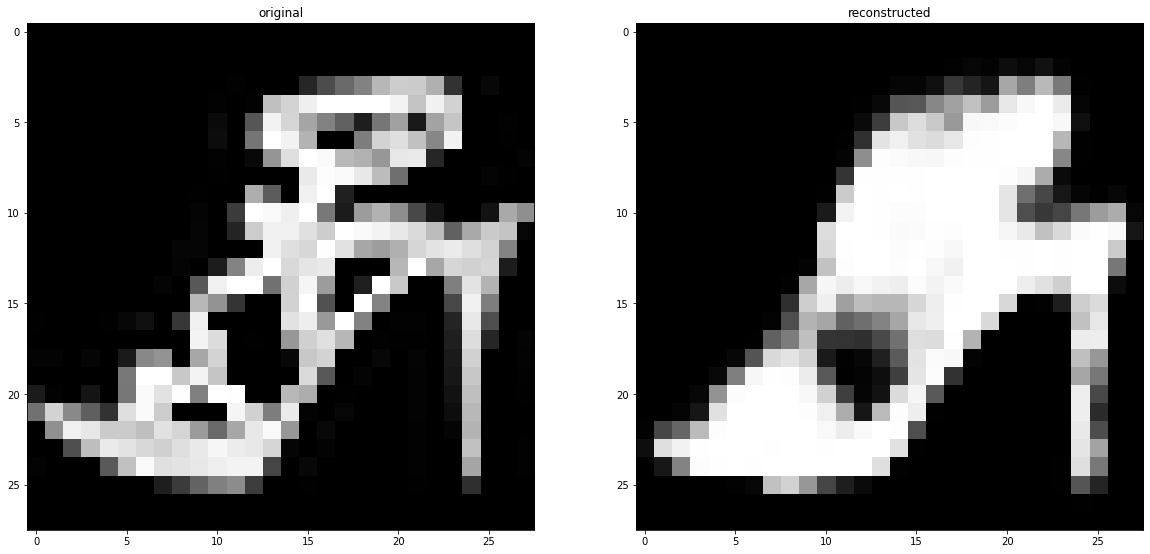


[EPOCH] ____________________91____________________
[91] - Finished Epoch in 3.37 seconds - train_loss: 0.5594; test_loss: 0.5597

[EPOCH] ____________________92____________________
[92] - Finished Epoch in 3.65 seconds - train_loss: 0.5595; test_loss: 0.5598

[EPOCH] ____________________93____________________
[93] - Finished Epoch in 3.33 seconds - train_loss: 0.5594; test_loss: 0.5598

[EPOCH] ____________________94____________________
[94] - Finished Epoch in 3.73 seconds - train_loss: 0.5591; test_loss: 0.5596

[EPOCH] ____________________95____________________
[95] - Finished Epoch in 3.16 seconds - train_loss: 0.5594; test_loss: 0.5594

[INFO] - Total time elapsed: 5.1366 min. Total time remaining: 0.2140 min.


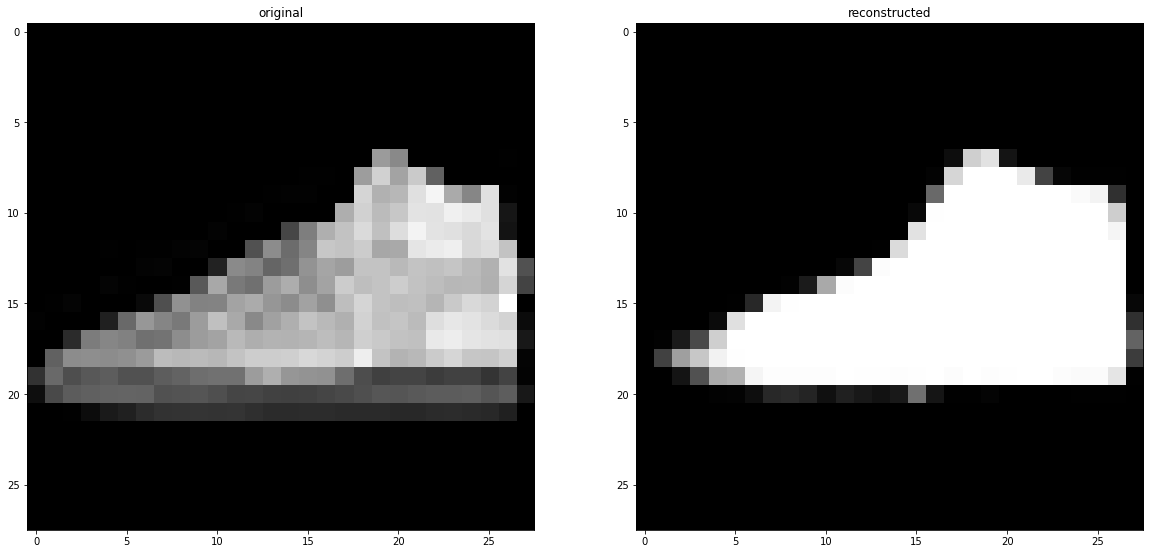


[EPOCH] ____________________96____________________
[96] - Finished Epoch in 3.76 seconds - train_loss: 0.5592; test_loss: 0.5602

[EPOCH] ____________________97____________________
[97] - Finished Epoch in 3.56 seconds - train_loss: 0.5592; test_loss: 0.5602

[EPOCH] ____________________98____________________
[98] - Finished Epoch in 3.32 seconds - train_loss: 0.5590; test_loss: 0.5594

[EPOCH] ____________________99____________________
[99] - Finished Epoch in 3.34 seconds - train_loss: 0.5592; test_loss: 0.5600
[INFO] - Total run time: 5.3697 min.


In [10]:
print(f'[INFO] - Evaluating the Dataset on the {model.name} before training.')
timer.start()

# evaluate once before training 
eval_step(model,
          train_ds,
          loss_function, 
          loss_metric=train_loss_metric)
train_loss = train_loss_metric.result()
train_losses.append(train_loss)

eval_step(model,  
        test_ds,
        loss_function, 
        loss_metric=test_loss_metric)
test_loss = test_loss_metric.result()
test_losses.append(test_loss)

train_loss_metric.reset_states()
test_loss_metric.reset_states()

elapsed_time = timer.stop()
times.append(elapsed_time)

print(f'train_loss: {train_loss:0.4f}, test_loss: {test_loss:0.4f}')

for epoch in range(EPOCHS):
    print(f'\n[EPOCH] ____________________{epoch}____________________')
    
    timer.start()
    
    # Training step    
    train_step(model, train_ds, loss_function, optimizer, train_loss_metric)
    
    # Test step    
    img_original, img_reconstructed = eval_step(model, test_ds, loss_function, test_loss_metric)
    
    # Evaluate the metrics
    test_loss = test_loss_metric.result()
    test_losses.append(test_loss)
    train_loss = train_loss_metric.result()
    train_losses.append(train_loss)
    
    elapsed_time = timer.stop()
    times.append(elapsed_time)

    print(f'[{epoch}] - Finished Epoch in {elapsed_time:0.2f} seconds - train_loss: {train_loss:0.4f}; test_loss: {test_loss:0.4f}')
    
    # print progress every while
    if epoch%5 == 0:
        print(f'\n[INFO] - Total time elapsed: {np.sum(times)/60:0.4f} min. Total time remaining: {(np.sum(times)/(epoch+1))*(EPOCHS-epoch-1)/60:0.4f} min.')
        # Visualize reconstructed image
        fig, ax = plt.subplots(ncols=2, figsize=(20,10))
        ax[0].imshow(img_original[0,:,:,0], cmap='gray')
        ax[0].set_title('original')
        ax[1].imshow(img_reconstructed[0,:,:,0], cmap='gray')
        ax[1].set_title('reconstructed')
        plt.pause(0.05)
        plt.show()

    # Resetting metrics 
    train_loss_metric.reset_states()
    test_loss_metric.reset_states()

print(f'\n[INFO] - Total run time: {np.sum(times)/60:0.4f} min.')

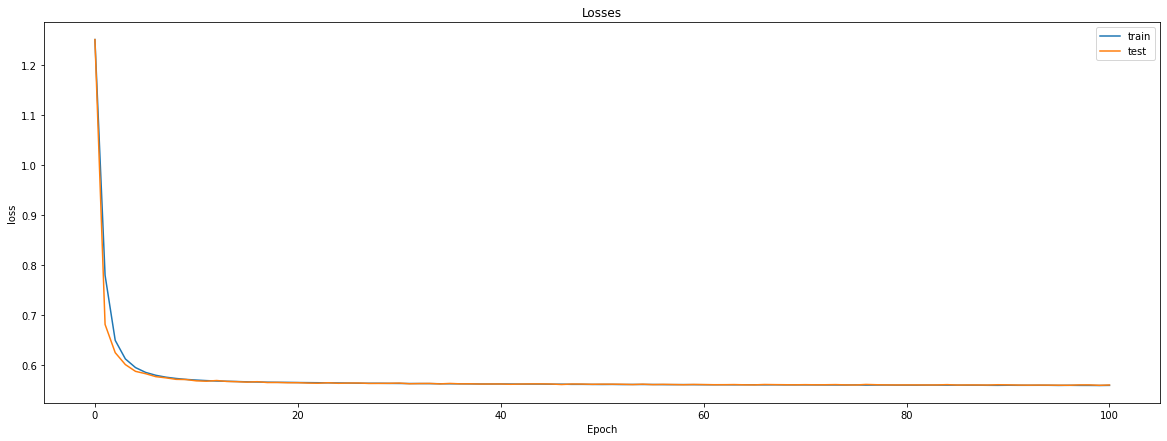

In [15]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(20,7))

x = np.arange(len(train_losses))

# losses
axes.plot(x, train_losses, label='train')
axes.plot(x, test_losses, label='test')
axes.legend()
axes.set(title='Losses', xlabel='Epoch', ylabel='loss')

plt.show()

tf.Tensor(9, shape=(), dtype=uint8)


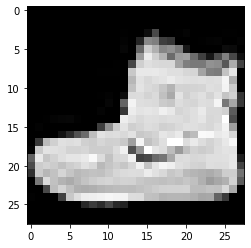

In [55]:
# load data; no need for labels, as we train autoencoders
(train_x, train_y), (test_x, test_y) = tf.keras.datasets.fashion_mnist.load_data()

eval_x = np.append(train_x, test_x, axis=0)
eval_y = np.append(train_y, test_y, axis=0)

eval_x = tf.data.Dataset.from_tensor_slices(eval_x)
eval_x = eval_x.map(lambda img: tf.expand_dims(img, axis=0))

eval_y = tf.data.Dataset.from_tensor_slices(eval_y)

# preprocess
eval_x = preprocess_tfds(eval_x, 
                         batch_size=None, 
                         buffer_size=None, 
                         prefetch_factor=None)

eval_ds = tf.data.Dataset.zip((eval_x, eval_y))

In [58]:
latent_representation = []
labels = []

for img, label in eval_ds:
    latent_representation.append(model.encoder(img).numpy())
    labels.append(label)
    
# latent_representation = np.array(latent_representation).reshape((-1, 10))

In [71]:
latent_ds = np.array(latent_representation).reshape((-1, 10))
latent_labels = np.array(labels)

In [75]:
tsne = TSNE(n_components=2, random_state=0)
tsne_obj= tsne.fit_transform(latent_ds)

In [104]:
label_code = ['T-Shirt', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle Boot']

latent_labels_string = [label_code[i] for i in latent_labels]

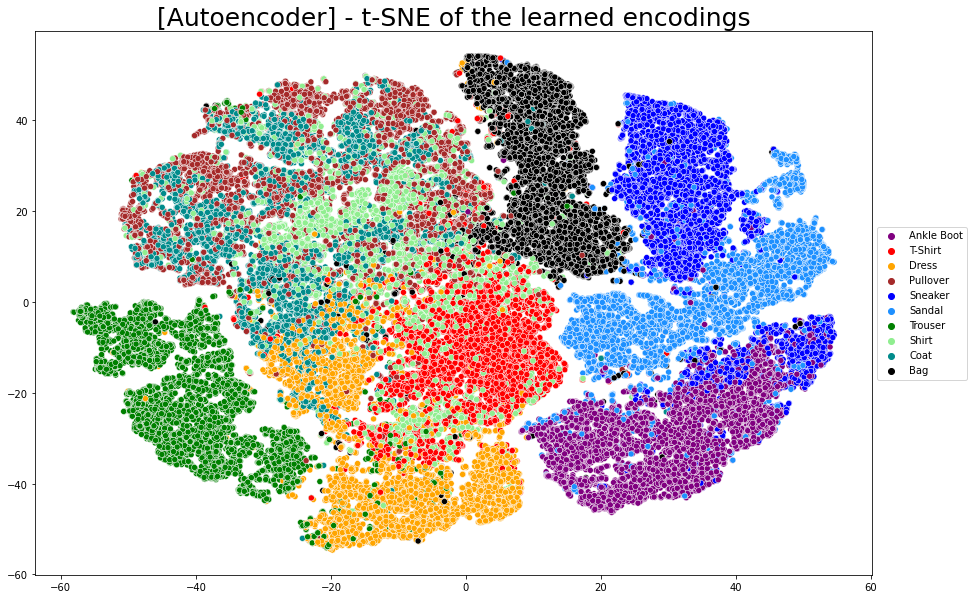

In [145]:
plt.figure(figsize=(15, 10))

tsne_plot = sns.scatterplot(x=tsne_obj[:,0], 
                            y=tsne_obj[:,1],
                            hue=latent_labels_string,
                            palette=['purple','red','orange','brown','blue',
                                    'dodgerblue','green','lightgreen','darkcyan', 'black'],
                            legend='full')

tsne_plot.legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=1)
tsne_plot.set_title('[Autoencoder] - t-SNE of the learned encodings', fontdict={'fontsize': 25})

plt.show()

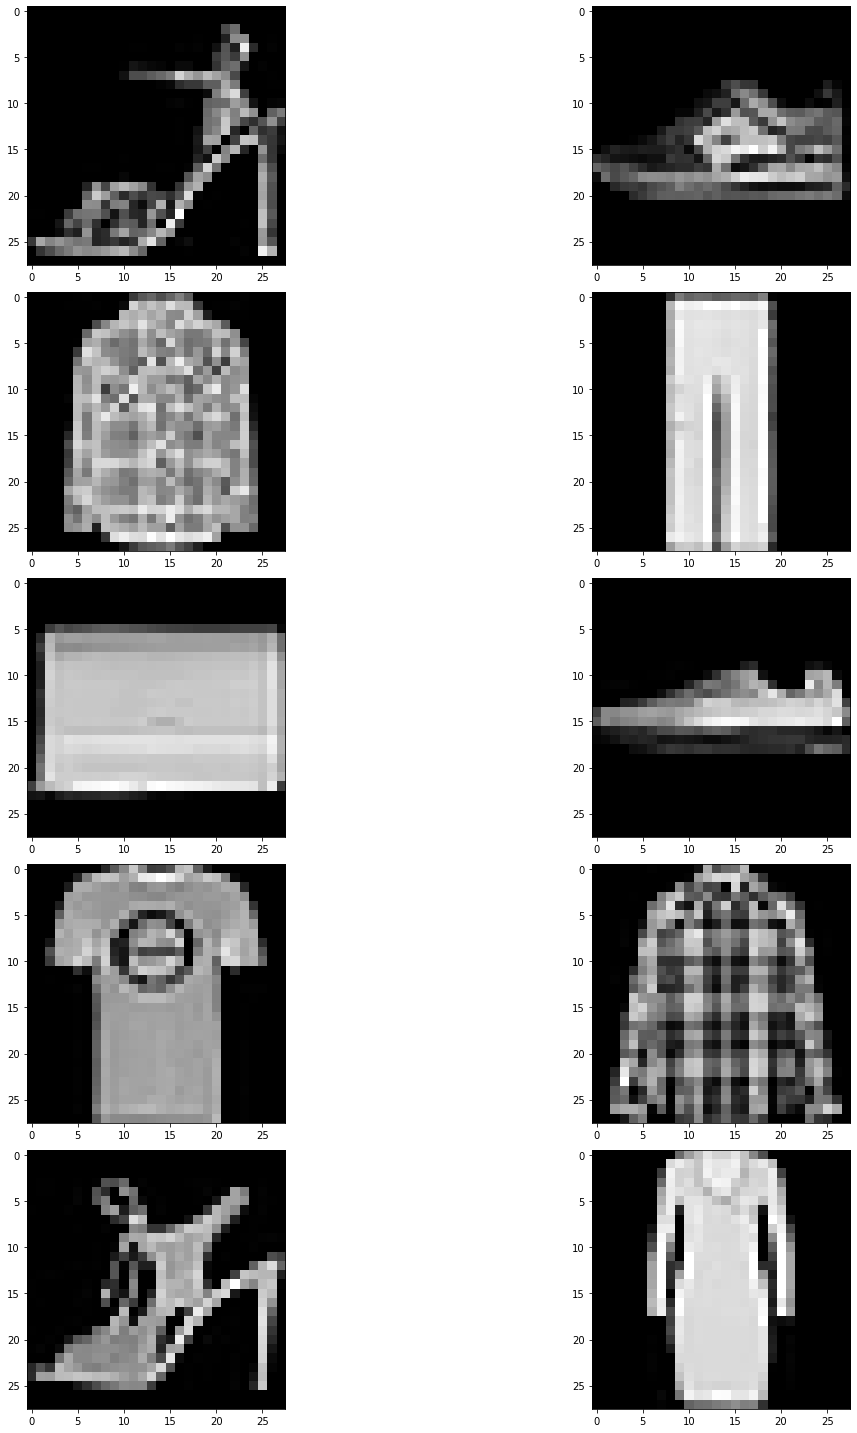

In [115]:
%matplotlib inline
fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(20,20))

for img in train_ds.take(1):
    i = 0
    for i, ax in enumerate(fig.axes):
        ax.imshow(img[i, :, :, 0], cmap='gray')
        
    break

plt.tight_layout(pad=1.)
plt.show()

# 3. Train/test and visualize VAE

In [161]:
# @Hyperparameter
EPOCHS = 100
LEARNING_RATE = 0.001

tf.keras.backend.clear_session()
timer = Timer()

# Define @model
model = CVAE(10)
# Define @optimizer
optimizer = tf.keras.optimizers.Adam(LEARNING_RATE)


In [162]:
train_loss_metric = tf.keras.metrics.Mean('train_loss')
test_loss_metric = tf.keras.metrics.Mean('test_loss')

# Initialize lists for later visualization.
train_losses = []
test_losses = []
times = []

In [169]:
print(f'[INFO] - Evaluating the Dataset on the {model.name} before training.')
timer.start()

# evaluate once before training 
eval_step_VAE(model,
          train_ds, 
          loss_metric=train_loss_metric)
train_loss = train_loss_metric.result()
train_losses.append(train_loss)

eval_step_VAE(model,  
        test_ds,
        loss_metric=test_loss_metric)
test_loss = test_loss_metric.result()
test_losses.append(test_loss)

train_loss_metric.reset_states()
test_loss_metric.reset_states()

elapsed_time = timer.stop()
times.append(elapsed_time)

print(f'train_loss: {train_loss:0.4f}, test_loss: {test_loss:0.4f}')

for epoch in range(EPOCHS):
    print(f'\n[EPOCH] ____________________{epoch}____________________')
    
    timer.start()
    
    # Training step    
    train_step_VAE(model, train_ds, optimizer, train_loss_metric)
    
    # Test step    
    eval_step_VAE(model, test_ds, test_loss_metric)
    
    # Evaluate the metrics
    test_loss = test_loss_metric.result()
    test_losses.append(test_loss)
    train_loss = train_loss_metric.result()
    train_losses.append(train_loss)
    
    elapsed_time = timer.stop()
    times.append(elapsed_time)

    print(f'[{epoch}] - Finished Epoch in {elapsed_time:0.2f} seconds - train_loss: {train_loss:0.4f}; test_loss: {test_loss:0.4f}')
    
    # print progress every while
    if epoch%5 == 0:
        print(f'\n[INFO] - Total time elapsed: {np.sum(times)/60:0.4f} min. Total time remaining: {(np.sum(times)/(epoch+1))*(EPOCHS-epoch-1)/60:0.4f} min.')
        # Visualize reconstructed image
        fig, ax = plt.subplots(ncols=2, figsize=(20,10))
        ax[0].imshow(img_original[0,:,:,0], cmap='gray')
        ax[0].set_title('original')
        ax[1].imshow(img_reconstructed[0,:,:,0], cmap='gray')
        ax[1].set_title('reconstructed')
        plt.pause(0.05)
        plt.show()

    # Resetting metrics 
    train_loss_metric.reset_states()
    test_loss_metric.reset_states()

print(f'\n[INFO] - Total run time: {np.sum(times)/60:0.4f} min.')

[INFO] - Evaluating the Dataset on the cvae before training.
Timer is running. Use .stop() to stop it


TypeError: call() takes 1 positional argument but 2 were given